In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [3]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
test_data_raw = np.loadtxt(open("../Datasets/mnist_test.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]
test_data = test_data_raw[:, 1:]
test_labels = test_data_raw[:, 0]

print(f"Train data shape: {train_data.shape, train_labels.shape}")
print(f"Test data shape: {test_data.shape, test_labels.shape}")

Train data shape: ((60000, 784), (60000,))
Test data shape: ((10000, 784), (10000,))


In [11]:
# Data normalization
train_data_norm = train_data / np.max(train_data)
test_data_norm = test_data / np.max(test_data)

# Binarized data
train_data_norm[train_data_norm > 0.5] = 1
train_data_norm[train_data_norm < 0.5] = 0
test_data_norm[test_data_norm > 0.5] = 1
test_data_norm[test_data_norm < 0.5] = 0

# train_data_norm[0]

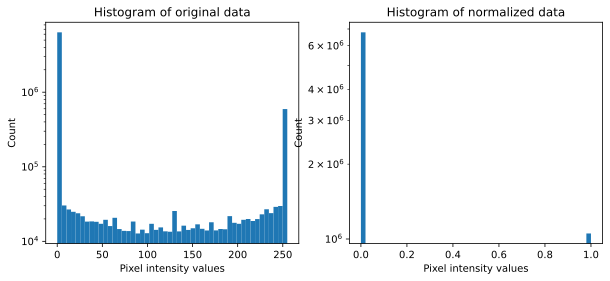

In [27]:
# Plot the data to see the data distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(test_data.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(test_data_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

plt.show()

In [28]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(train_data_norm).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_data_tensor = torch.tensor(test_data_norm).float()
test_labels_tensor = torch.tensor(test_labels).long()

# Test and dev set split
dev_dataset, test_dataset, dev_label, test_label = train_test_split(
    test_data_tensor, test_labels_tensor, test_size=0.5
)

# Convert into pytorch dataset
train_dataT = TensorDataset(train_data_tensor, train_labels_tensor)
dev_dataT = TensorDataset(dev_dataset, dev_label)
test_dataT = TensorDataset(test_dataset, test_label)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
devset_loader = DataLoader(
    dev_dataT,
    batch_size=dev_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)
testset_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [29]:
# To check all the variables in the workspace
%whos

Variable              Type             Data/Info
------------------------------------------------
DataLoader            type             <class 'torch.utils.data.dataloader.DataLoader'>
F                     module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset         type             <class 'torch.utils.data.dataset.TensorDataset'>
X                     Tensor           tensor([[0., 0., 0.,  ...<...>., 0.]], device='cuda:0')
ax                    ndarray          2: 2 elems, type `object`, 16 bytes
backend_inline        module           <module 'matplotlib_inlin<...>nline/backend_inline.py'>
batchsize             int              32
corr_Idx              tuple            n=1
createNewMNISTNet     function         <function createNewMNISTNet at 0x7f5cd5cedf80>
devAcc                list             n=30
dev_dataT             TensorDataset    <torch.utils.data.dataset<...>object at 0x7f5c49597170>
dev_dataset           Tensor           tensor([[0., 0., 

In [15]:
# Create the model function
def createNewMNISTNet(lr=0.01):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(784, 128)

            # Hidden Layers
            self.hidden1 = nn.Linear(128, 256)
            self.hidden2 = nn.Linear(256, 256)
            self.hidden3 = nn.Linear(256, 128)
            self.hidden4 = nn.Linear(128, 32)

            # Output Layer
            self.output = nn.Linear(32, 10)

        # Forward Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = F.relu(self.hidden3(x))
            x = F.relu(self.hidden4(x))
            return torch.log_softmax(self.output(x), axis=1)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.NLLLoss()
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lossFun, optimizer

In [16]:
# Test the model
net, lossFun, optimizer = createNewMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

loss = lossFun(yHat, y)

print(f"Loss: {loss}")
print(yHat)

Loss: 2.321763753890991
tensor([[-2.3140, -2.2118, -2.2035, -2.3346, -2.3380, -2.2743, -2.2710, -2.3308,
         -2.3588, -2.4078],
        [-2.3124, -2.2125, -2.2044, -2.3354, -2.3380, -2.2753, -2.2705, -2.3292,
         -2.3587, -2.4081],
        [-2.3126, -2.2138, -2.2039, -2.3346, -2.3388, -2.2734, -2.2710, -2.3291,
         -2.3589, -2.4083],
        [-2.3126, -2.2135, -2.2012, -2.3359, -2.3383, -2.2730, -2.2705, -2.3288,
         -2.3606, -2.4107],
        [-2.3124, -2.2113, -2.2020, -2.3360, -2.3371, -2.2740, -2.2728, -2.3307,
         -2.3617, -2.4068],
        [-2.3138, -2.2138, -2.2009, -2.3337, -2.3392, -2.2739, -2.2726, -2.3329,
         -2.3583, -2.4053],
        [-2.3114, -2.2128, -2.2015, -2.3350, -2.3392, -2.2739, -2.2735, -2.3287,
         -2.3601, -2.4086],
        [-2.3132, -2.2131, -2.2043, -2.3344, -2.3398, -2.2740, -2.2713, -2.3291,
         -2.3577, -2.4074],
        [-2.3118, -2.2120, -2.2013, -2.3365, -2.3373, -2.2743, -2.2711, -2.3308,
         -2.3606, -2.40

In [17]:
# Function to train the model
nEpochs = 30


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet(lr=0.005)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    devAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = net(X)

        devAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu())
    # End of epoch

    return trainAcc, devAcc, losses, net

In [18]:
trainAcc, devAcc, losses, net = trainTheModel()

In [19]:
# Function to check the test Accuracy
def testModePerformance(dataset):
    testAcc = []
    # Model in evaluation mode
    net.eval()

    for X, y in dataset:
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100 * (torch.argmax(yHat, axis=1) == y).float().cpu())

    return testAcc


testAcc = testModePerformance(testset_loader)

In [20]:
print(f"Train Accuracy is : {trainAcc[-1]}")
print(f"Dev Accuracy is : {devAcc[-1]}")
print(f"Test Accuracy is : {np.mean(testAcc)}")
print(len(testAcc), len(devAcc))
print(np.array(testAcc[0].detach()).shape)

Train Accuracy is : 96.47000122070312
Dev Accuracy is : 95.54000091552734
Test Accuracy is : 95.62000274658203
1 30
(5000,)


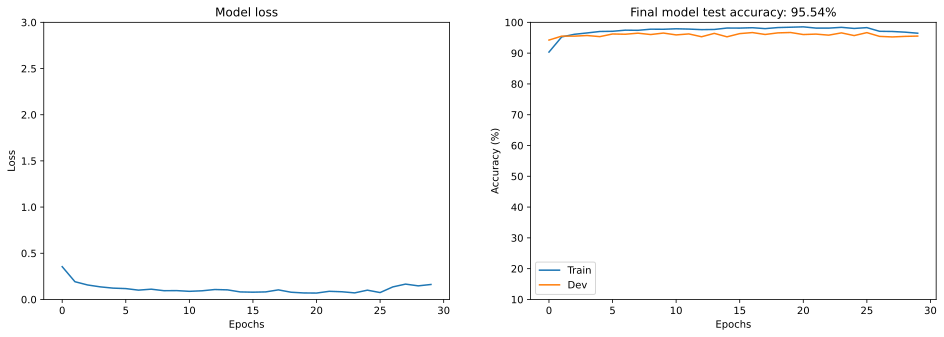

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(devAcc, label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {devAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [30]:
# run the model through for the test data
X, y = next(iter(testset_loader))
predictions = net(X).detach()

predictions

tensor([[-6.2004e+01, -1.1794e+02, -5.7125e+01,  ..., -2.8362e+01,
         -3.9889e+01, -4.1723e-06],
        [-6.3808e+01, -8.8465e+01, -5.7034e+01,  ...,  0.0000e+00,
         -1.0911e+02, -5.0545e+01],
        [-2.9408e+01, -2.3710e+01, -2.0327e+01,  ..., -2.1486e+01,
         -2.2647e+01, -1.1236e+01],
        ...,
        [-9.1869e-02, -5.7533e+00, -4.5040e+00,  ..., -4.9205e+00,
         -3.5610e+00, -5.0616e+00],
        [-1.3615e+01, -9.1966e+00, -4.8480e+00,  ..., -3.1714e+00,
         -4.6521e+00, -4.4547e+00],
        [-5.5937e+00, -9.5230e+00, -9.4032e+00,  ..., -1.0338e+01,
         -7.6793e-03, -6.9006e+00]], device='cuda:0')

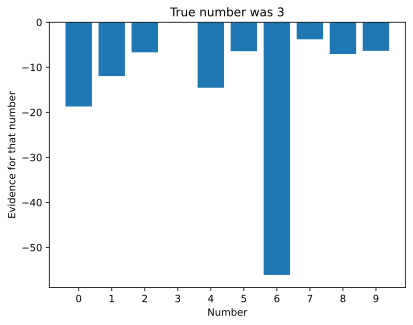

In [32]:
# Evidence for all numbers from one sample
sample2show = 122

plt.bar(range(10), predictions[sample2show].cpu())  # try adding exp!
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.title("True number was %s" % y[sample2show].item())
plt.show()

[   3   56   82  110  116  117  124  154  159  160  165  193  214  216
  222  245  276  309  323  346  451  462  464  470  478  497  542  554
  555  558  561  566  588  595  652  727  729  750  758  770  779  781
  812  824  856  874  888  918  927  940  945  974 1005 1026 1048 1107
 1113 1116 1131 1136 1153 1154 1157 1167 1172 1230 1258 1293 1295 1318
 1322 1336 1373 1417 1439 1442 1444 1445 1496 1499 1504 1537 1588 1650
 1683 1694 1707 1718 1721 1806 1845 1848 1862 1922 1984 1994 2017 2030
 2066 2104 2111 2211 2213 2224 2272 2301 2316 2348 2350 2354 2446 2451
 2469 2489 2498 2548 2553 2610 2612 2632 2641 2689 2721 2725 2750 2781
 2803 2819 2827 2851 2886 2940 3022 3084 3101 3125 3132 3170 3209 3237
 3246 3249 3280 3295 3321 3339 3378 3380 3401 3421 3423 3424 3463 3475
 3509 3541 3544 3570 3589 3626 3637 3642 3661 3711 3714 3736 3745 3748
 3749 3783 3803 3815 3838 3868 3887 3910 3981 4028 4078 4133 4151 4206
 4214 4229 4268 4269 4300 4348 4357 4375 4419 4449 4475 4490 4505 4510
 4520 

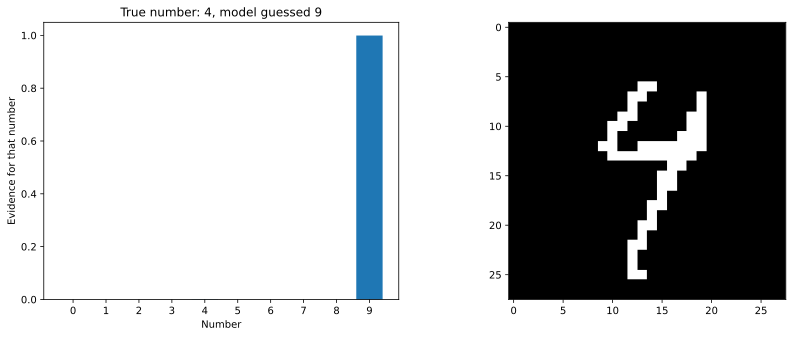

In [33]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1].cpu() != y.cpu())[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 11

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]].cpu()))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that number")
ax[0].set_title(
    "True number: %s, model guessed %s"
    % (
        y[errors[sample2show]].cpu().item(),
        torch.argmax(predictions[errors[sample2show]]).cpu().item(),
    )
)

ax[1].imshow(np.reshape(X[errors[sample2show], :].cpu(), (28, 28)), cmap="gray")

plt.show()

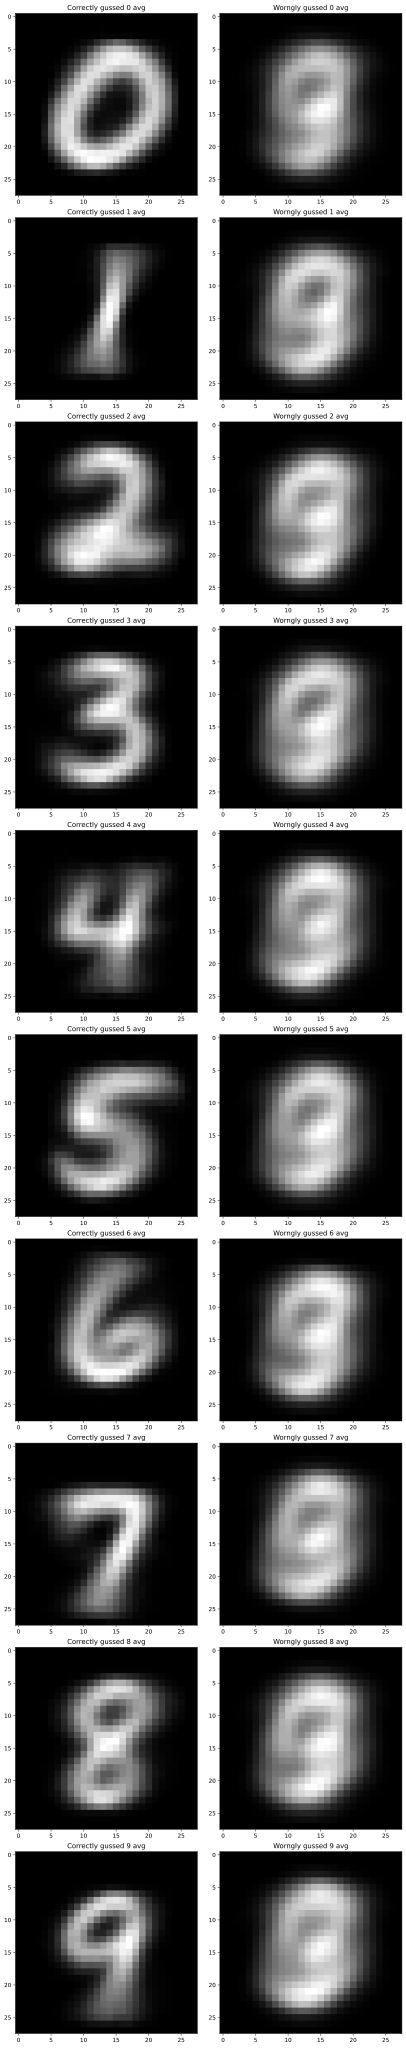

In [34]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?

# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.

X, y = next(iter(testset_loader))
predictions = net(X).cpu().detach()

nums = np.arange(0, 10)
results = np.zeros((len(nums), 2))
fig, ax = plt.subplots(
    results.shape[0], results.shape[1], figsize=(10, 50), constrained_layout=True
)
# fig.tight_layout()
for i in nums:
    errors_Idx = np.where(torch.max(predictions, axis=1)[1].cpu() != i)
    corr_Idx = np.where(torch.max(predictions, axis=1)[1].cpu() == i)

    ax[i][0].imshow(torch.mean(X[corr_Idx], axis=0).reshape(28, 28).cpu(), cmap="gray")
    ax[i][0].set_title(f"Correctly gussed {i} avg")
    ax[i][1].imshow(
        torch.mean(X[errors_Idx], axis=0).reshape(28, 28).cpu(), cmap="gray"
    )
    ax[i][1].set_title(f"Worngly gussed {i} avg")
plt.show()

In [35]:
print(X[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [26]:
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
#
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
#